# Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import mse_loss
import torchvision.transforms.functional as F
from PIL import Image

# Model

In [17]:
class SimpleSuperResolutionCNN(nn.Module):
    def __init__(self, upscale_factor=4):
        super(SimpleSuperResolutionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(32, 3 * (upscale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x
    

# Dataset

In [20]:
class HRImageDataset(Dataset):
    def __init__(self, hr_folder, scale_factor, transform=None):
        """
        Args:
            hr_folder (str): Path to the folder containing high-resolution images.
            scale_factor (int): Factor by which HR images are downscaled to create LR images.
            transform (callable, optional): Optional transform to apply to HR images.
        """
        self.hr_images = ImageFolder(hr_folder, transform=None)  # Keep raw PIL images
        self.scale_factor = scale_factor
        self.transform = transform

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_img, _ = self.hr_images[idx]  # HR image as a PIL Image

        # Perform nearest-neighbor downsampling
        lr_img = hr_img.resize(
            (hr_img.width // self.scale_factor, hr_img.height // self.scale_factor), 
            resample=Image.NEAREST
        )

        # Apply optional transformations (convert to tensor, normalization, etc.)
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)

        return lr_img, hr_img
        

# Parameters

In [54]:
learning_rate = 0.0001
batch_size = 8
num_epochs = 10
upscale_factor = 4

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
dataset = HRImageDataset("../data/", upscale_factor, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Optimizer, LossFunction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSuperResolutionCNN(upscale_factor=upscale_factor).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            optimizer.zero_grad()
            sr_img = model(lr_img)
            loss = mse_loss(sr_img, hr_img)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}')

# Training

In [55]:
train(model, dataloader, optimizer, 100)

Epoch 1/100, Loss: 0.153351986171821
Epoch 2/100, Loss: 0.016034449844692763
Epoch 3/100, Loss: 0.010438032475156853
Epoch 4/100, Loss: 0.008302662503690673
Epoch 5/100, Loss: 0.0067901813174383
Epoch 6/100, Loss: 0.005937555491422804
Epoch 7/100, Loss: 0.005290554406551214
Epoch 8/100, Loss: 0.004807851886233458
Epoch 9/100, Loss: 0.004431116900657519
Epoch 10/100, Loss: 0.004162734768425043
Epoch 11/100, Loss: 0.003987069505875787
Epoch 12/100, Loss: 0.003874533073170684
Epoch 13/100, Loss: 0.003795342376598945
Epoch 14/100, Loss: 0.0037333904452120457
Epoch 15/100, Loss: 0.003685451175372761
Epoch 16/100, Loss: 0.0036507927132054018
Epoch 17/100, Loss: 0.0036162325660160813
Epoch 18/100, Loss: 0.0035886012326675253
Epoch 19/100, Loss: 0.0035610389582311306
Epoch 20/100, Loss: 0.003538659814064606
Epoch 21/100, Loss: 0.003517523295998287
Epoch 22/100, Loss: 0.0035004183211220573
Epoch 23/100, Loss: 0.003480484180797178
Epoch 24/100, Loss: 0.003466393368748518
Epoch 25/100, Loss: 0.00

In [56]:
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def evaluate_model(model, hr_image_path, scale_factor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load HR image
    hr_image = Image.open(hr_image_path).convert("RGB")
    hr_image = to_tensor(hr_image).unsqueeze(0).to(device)  # Move HR image to device

    # Downsample to create LR image
    _, _, h, w = hr_image.shape
    lr_image = F.interpolate(hr_image, size=(h // scale_factor, w // scale_factor), mode="nearest").to(device)

    # Bilinear Upsampling for comparison
    bilinear_upsampled = F.interpolate(lr_image, size=(h, w), mode="bilinear", align_corners=False).to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        model_output = model(lr_image)

    # Metrics computation
    mse_model = F.mse_loss(model_output, hr_image)
    psnr_model = 10 * torch.log10(1 / mse_model)
    ssim_model = ssim(
        model_output.squeeze(0).permute(1, 2, 0).cpu().numpy(),
        hr_image.squeeze(0).permute(1, 2, 0).cpu().numpy(),
        multichannel=True,
        win_size=3,
        data_range=1.0  # Assuming images are normalized to [0, 1]
    )

    mse_bilinear = F.mse_loss(bilinear_upsampled, hr_image)
    psnr_bilinear = 10 * torch.log10(1 / mse_bilinear)
    ssim_bilinear = ssim(
        bilinear_upsampled.squeeze(0).permute(1, 2, 0).cpu().numpy(),
        hr_image.squeeze(0).permute(1, 2, 0).cpu().numpy(),
        multichannel=True,
        win_size=3,
        data_range=1.0  # Assuming images are normalized to [0, 1]
    )

    # Display results
    print(f"Model Output: MSE = {mse_model:.4f}, PSNR = {psnr_model:.2f}, SSIM = {ssim_model:.4f}")
    print(f"Bilinear Upsampling: MSE = {mse_bilinear:.4f}, PSNR = {psnr_bilinear:.2f}, SSIM = {ssim_bilinear:.4f}")

    # Visualize results
    visualize_results(lr_image, model_output, bilinear_upsampled, hr_image)


def visualize_results(lr_image, model_output, bilinear_upsampled, hr_image):
    """
    Visualize LR image, model output, bilinear upsampling, and ground truth.

    Args:
        lr_image: Low-resolution image.
        model_output: Model's output image.
        bilinear_upsampled: Bilinear upsampled image.
        hr_image: Ground truth high-resolution image.

    Returns:
        None
    """
    lr_image = to_pil_image(lr_image.squeeze(0).cpu())  # Move back to CPU for visualization
    model_output = to_pil_image(model_output.squeeze(0).clamp(0, 1).cpu())
    bilinear_upsampled = to_pil_image(bilinear_upsampled.squeeze(0).clamp(0, 1).cpu())
    hr_image = to_pil_image(hr_image.squeeze(0).cpu())

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low-Resolution Image")
    axes[1].imshow(model_output)
    axes[1].set_title("Model Output")
    axes[2].imshow(bilinear_upsampled)
    axes[2].set_title("Bilinear Upsampling")
    axes[3].imshow(hr_image)
    axes[3].set_title("Ground Truth")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Model Output: MSE = 0.0061, PSNR = 22.17, SSIM = 0.7432
Bilinear Upsampling: MSE = 0.0049, PSNR = 23.12, SSIM = 0.7835


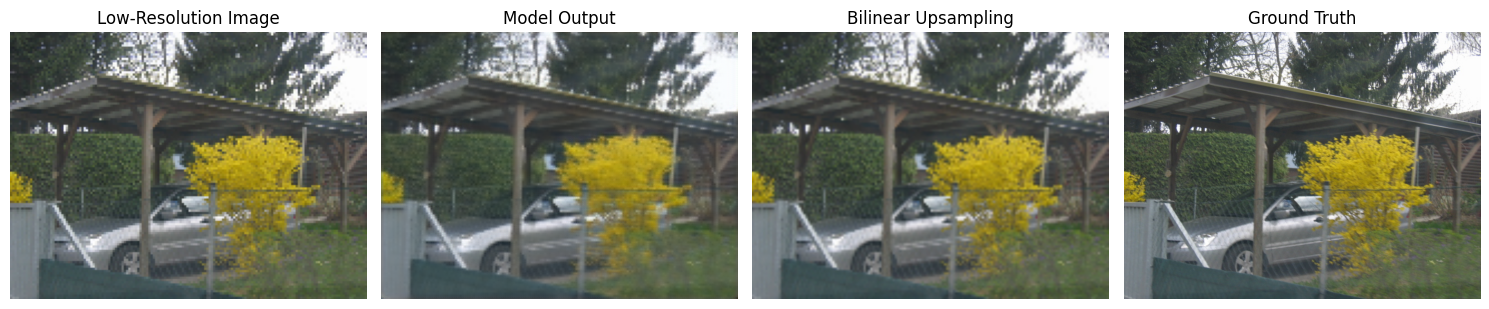

CPU times: total: 797 ms
Wall time: 1.43 s


In [66]:
%%time

hr_image_path = "../data/cars/carsgraz_360.bmp"

evaluate_model(model, hr_image_path, 4)

In [67]:
# Load HR image
hr_image = Image.open(hr_image_path).convert("RGB")
hr_image = to_tensor(hr_image).unsqueeze(0).to(device)  # Move HR image to device

# Downsample to create LR image
_, _, h, w = hr_image.shape
scale_factor = 4
lr_image = F.interpolate(hr_image, size=(h // scale_factor, w // scale_factor), mode="nearest").to(device)

In [70]:
%%timeit

res = model(lr_image)

1.96 ms ± 63.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
# close torch
torch.cuda.empty_cache()